In [1]:
# # Colab execute.
# from google.colab import drive


# drive.mount('/content/drive')
# _path = '/content/drive/MyDrive/antenna-performance-prediction/antenna-performance-prediction'
# %cd /content/drive/MyDrive/antenna-performance-prediction/antenna-performance-prediction/

In [2]:
import pandas as pd
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import time
from mylibrary import manipulation
from mylibrary import visualization as visual

# Local execute.
origin_train = pd.read_csv('dataset/train.csv')
origin_test = pd.read_csv('dataset/test.csv')
x_info = pd.read_csv('dataset/meta/x_feature_info.csv')
y_info = pd.read_csv('dataset/meta/y_feature_info.csv')
submission = pd.read_csv("dataset/sample_submission.csv")

# Colab execute.
# origin_train = pd.read_csv(f'{_path}/dataset/train.csv')
# origin_test = pd.read_csv(f'{_path}/dataset/test.csv')
# x_info = pd.read_csv(f'{_path}/dataset/meta/x_feature_info.csv')
# y_info = pd.read_csv(f'{_path}/dataset/meta/y_feature_info.csv')
# submission = pd.read_csv(f'{_path}/dataset/sample_submission.csv')


x_train = origin_train.filter(regex='X')
y_train = origin_train.filter(regex='Y')

x_test = origin_test.drop(columns=['ID'])

x_name = manipulation.make_namegroup(x_train, x_info)
y_name = manipulation.make_namegroup(y_train, y_info)

visual.print_namegroup(x_name)
print()
visual.print_namegroup(y_name)

PCB 체결 시 단계별 누름량(Step n): X_01  X_02  X_05  X_06
방열 재료 n 무게: X_03  X_10  X_11
n차 검사 통과 여부: X_04  X_23  X_47  X_48
방열 재료 n 면적: X_07  X_08  X_09
커넥터 위치 기준 좌표: X_12
각 안테나 패드 위치(높이) 차이: X_13
n번 안테나 패드 위치: X_14  X_15  X_16  X_17  X_18
n번 스크류 삽입 깊이: X_19  X_20  X_21  X_22
커넥터 n번 핀 치수: X_24  X_25  X_26  X_27  X_28  X_29
스크류 삽입 깊이n: X_30  X_31  X_32  X_33
스크류 체결 시 분당 회전수 n: X_34  X_35  X_36  X_37
하우징 PCB 안착부 n 치수: X_38  X_39  X_40
레이돔 치수 (안테나 n번 부위): X_41  X_42  X_43  X_44
안테나 부분 레이돔 기울기: X_45
실란트 본드 소요량: X_46
Cal 투입 전 대기 시간: X_49
RFn 부분 SMT 납 량: X_50  X_51  X_52  X_53  X_54  X_55  X_56

안테나 Gain 평균 (각도n): Y_01  Y_05  Y_07  Y_11
안테나 n Gain 편차: Y_02  Y_03
평균 신호대 잡음비: Y_04
신호대 잡음비 (각도n): Y_06  Y_08  Y_09  Y_10  Y_12  Y_13  Y_14


In [3]:
from sklearn.preprocessing import RobustScaler


# n차 검사 통과 여부
# 모든 값이 1임.
x_train = x_train.drop(columns=x_name['n차 검사 통과 여부'])
x_test = x_test.drop(columns=x_name['n차 검사 통과 여부'])

# 방열 재료 n 무게
# 'X_10','X_11'은 결측값이 절대 다수이고,
# 결측값과 아닌 값 사이의 뚜렷한 차이가 나타나지 않음.
x_train = x_train.drop(columns=['X_10','X_11'])
x_test = x_test.drop(columns=['X_10','X_11'])

# 실란트 본드 소요량
# 'X_46'은 예측하려는 값이나 다른 X값보다 그 크기가 훨씬 크다.
transformer = RobustScaler().fit(x_train[['X_46']])
x_train['X_46'] = transformer.transform(x_train[['X_46']])
x_test['X_46'] = transformer.transform(x_test[['X_46']])

# Cal 투입 전 대기 시간
# 'X_49'는 예측하려는 값이나 다른 X값보다 그 크기가 훨씬 크다.
transformer = RobustScaler().fit(x_train[['X_49']])
x_train['X_49'] = transformer.transform(x_train[['X_49']])
x_test['X_49'] = transformer.transform(x_test[['X_49']])

In [4]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.666885,0.000,0.029851,-0.095397,1.666885,0.308081,-1.977469,0.149297,-1.000000,1.333333,...,2.000000,-6.0,-1.246527,0.832656,0.534110,1.131924,0.868767,-0.367227,-0.141617,-0.505029
1,0.333442,0.001,-0.313433,-0.051883,1.000000,-0.055556,-2.020653,-0.011138,0.333333,1.333333,...,-0.285714,-6.0,-1.085900,0.396989,0.616846,1.385566,-0.605928,-0.030251,0.650943,-0.527542
2,1.333442,0.000,-0.477612,0.959833,1.000000,-0.015152,-0.348104,0.500530,-0.333333,0.333333,...,-0.142857,-1.0,-0.968329,0.274258,-0.039661,1.007532,0.126869,-0.160030,0.299524,-0.921137
3,1.000000,0.000,0.044776,-0.029289,2.333442,0.040404,0.006384,0.277247,-1.333333,2.333333,...,1.000000,0.0,-0.059625,0.449959,0.251508,0.145199,0.585413,0.386544,1.167473,0.963561
4,0.333442,0.000,-0.552239,-0.020921,0.333442,0.424242,-0.437852,0.092946,-0.666667,0.666667,...,1.000000,0.0,-0.945379,1.581675,0.702195,-0.446335,0.930441,-0.360987,0.171708,-0.766846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,-0.666558,0.000,-0.746269,0.957322,-1.000000,0.686869,-1.397296,0.843278,-0.333333,0.333333,...,-0.571429,0.0,10.155589,-0.099815,-0.072751,-0.613080,-0.379187,-0.930518,-0.494758,0.091768
39603,-0.666558,0.001,-0.671642,0.012552,-1.000000,0.186869,-0.480285,0.480244,1.000000,-0.333333,...,-0.428571,-11.0,10.185301,-0.407025,-1.492346,0.503489,-0.766761,-0.752852,0.623099,-0.835652
39604,0.000000,0.000,-0.388060,0.952301,-0.333442,0.565657,-0.466767,-0.482365,0.333333,0.000000,...,-0.285714,-10.0,-1.446404,0.234230,0.738590,-0.499116,0.151215,0.415554,0.310755,-1.379229
39605,-0.666558,0.000,-0.537313,0.015900,-0.666558,0.737374,-0.091626,0.544551,-1.333333,0.666667,...,-0.571429,0.0,10.511951,-0.333802,-1.314081,0.335775,0.292880,-0.379982,-0.155759,-0.579947


In [5]:
x_test

array([[ 0.00000000e+00,  1.00000000e-03,  1.40298507e+00, ...,
         2.37537325e-01, -5.71840180e-01, -9.77593834e-01],
       [-3.33115397e-01,  0.00000000e+00,  3.13432836e-01, ...,
         6.35205003e-01, -5.12898039e-01, -6.31744290e-01],
       [ 3.33442301e-01,  0.00000000e+00,  2.53731343e-01, ...,
         2.87645259e-01, -1.15836016e+00, -2.07886144e+00],
       ...,
       [ 3.33442301e-01,  0.00000000e+00, -5.37313433e-01, ...,
        -2.97985571e-01, -2.69518598e-01, -1.10870588e-01],
       [-3.33115397e-01,  1.00000000e-03, -8.20895522e-01, ...,
         1.76474457e-01, -6.27563446e-01,  5.17280441e-01],
       [ 1.00000000e+00,  0.00000000e+00, -6.26865672e-01, ...,
         5.38945660e-01,  2.40418941e-01, -1.03434105e+00]])

In [6]:
start_t = time.time()

###
# model = xgb.XGBRegressor()
model = RandomForestRegressor()
multi_model = MultiOutputRegressor(model)
multi_model.fit(x_train, y_train)
y_pred = multi_model.predict(x_test)
###


end_t = time.time()
t = time.gmtime(end_t - start_t)
print(f"[Training time] => {t.tm_min}(min) {t.tm_sec}(sec)")

[Training time] => 39(min) 42(sec)


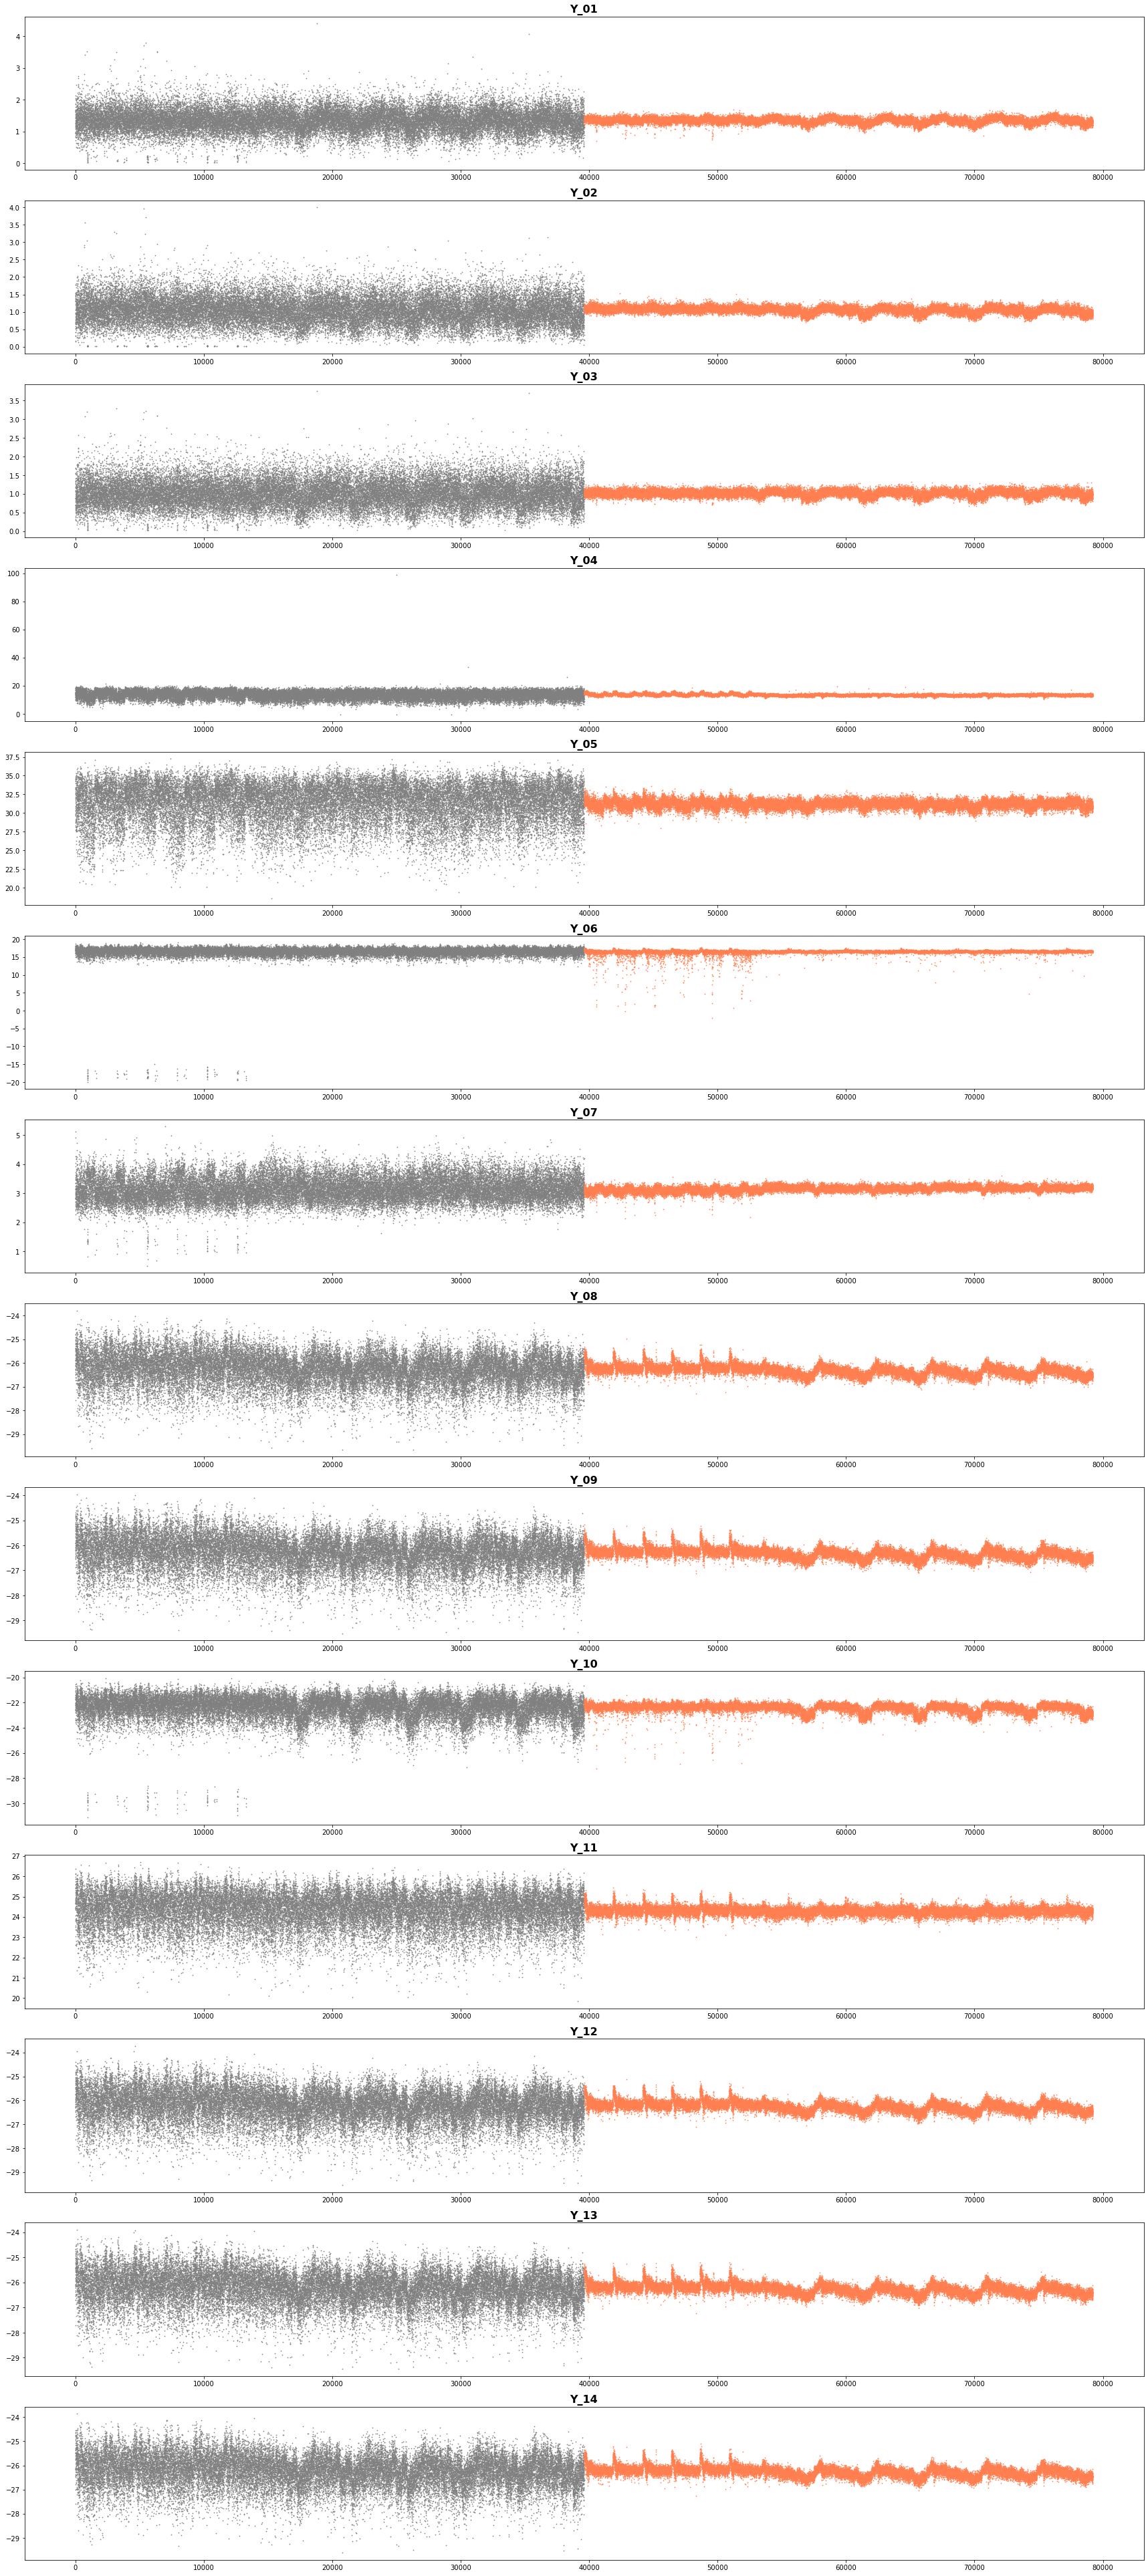

In [7]:
visual.show_pred(origin_train.filter(regex='Y'), y_pred)

In [8]:
for idx, col in enumerate(submission.columns):
    if col == 'ID':
        continue
    submission[col] = y_pred[:, idx-1]
    

submission.to_csv(f"submissions/{time.asctime().replace(':', '-')}.csv", index=False)
print('Done.')

Done.
